In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

DATA_CLEAN = Path("../data/processed/reviews_clean.csv")  
MODELS_DIR = Path("../models")
OUT_DIR = Path("../outputs")
CHART_DIR = OUT_DIR / "charts"
OUT_DIR.mkdir(exist_ok=True, parents=True)
CHART_DIR.mkdir(exist_ok=True, parents=True)


In [7]:
# Load the cleaned dataset
df = pd.read_csv(DATA_CLEAN)

# One fixed split for fair comparisons
X = df["text_clean"].astype(str)
y = df["label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

len(X_train), len(X_test), y_test.value_counts()


(27728,
 6932,
 label
 positive    6463
 neutral      307
 negative     162
 Name: count, dtype: int64)

In [8]:
def evaluate_model(model_path: Path, name: str):
    pipe = joblib.load(model_path)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=["negative","neutral","positive"])
    return {
        "name": name,
        "accuracy": acc,
        "macro_f1": report["macro avg"]["f1-score"],
        "neg_recall": report["negative"]["recall"] if "negative" in report else np.nan,
        "neu_recall": report["neutral"]["recall"] if "neutral" in report else np.nan,
        "pos_recall": report["positive"]["recall"] if "positive" in report else np.nan,
        "cm": cm,
        "y_pred": y_pred,
    }


In [9]:
results = []

paths = [
    (MODELS_DIR / "tfidf_logreg_pipeline.joblib", "TF-IDF + Logistic Regression"),
    (MODELS_DIR / "tfidf_svm_pipeline.joblib", "TF-IDF + Linear SVM"),
    (MODELS_DIR / "tfidf_svm_oversampled.joblib", "TF-IDF + Linear SVM (oversample)"),
    (MODELS_DIR / "tfidf_svm_hybrid.joblib", "TF-IDF + Linear SVM (hybrid)"),
]

for p, name in paths:
    if p.exists():
        res = evaluate_model(p, name)
        results.append(res)
    else:
        print(f"Missing model: {p.name}")

len(results)


4

In [10]:
summary_rows = []
for r in results:
    summary_rows.append({
        "Model": r["name"],
        "Accuracy": round(r["accuracy"], 4),
        "Macro F1": round(r["macro_f1"], 4),
        "Recall (neg)": round(r["neg_recall"], 4) if r["neg_recall"] is not None else None,
        "Recall (neu)": round(r["neu_recall"], 4) if r["neu_recall"] is not None else None,
        "Recall (pos)": round(r["pos_recall"], 4) if r["pos_recall"] is not None else None,
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="Macro F1", ascending=False)
summary_df


,Model,Accuracy,Macro F1,Recall (neg),Recall (neu),Recall (pos)
3,TF-IDF + Linear SVM (hybrid),0.9347,0.5854,0.4074,0.2573,0.9800
2,TF-IDF + Linear SVM (oversample),0.9259,0.5620,0.3704,0.2964,0.9697
1,TF-IDF + Linear SVM,0.9233,0.5422,0.3333,0.2866,0.9683
0,TF-IDF + Logistic Regression,0.6724,0.3562,0.0432,0.8111,0.6816


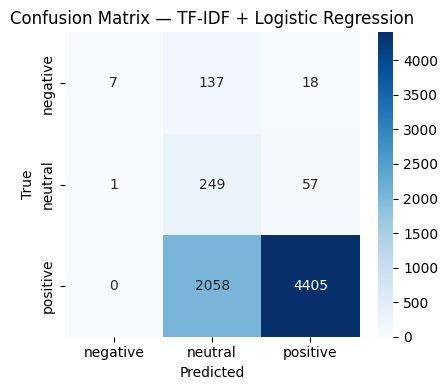

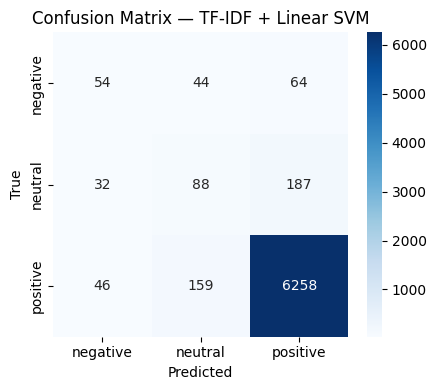

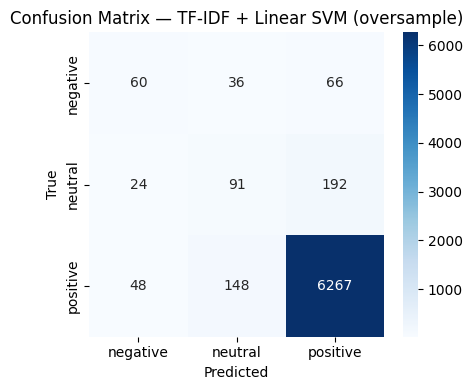

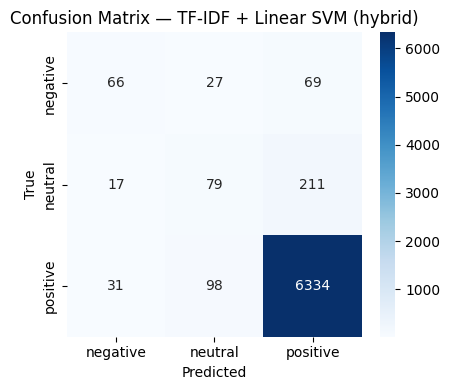

In [11]:
labels = ["negative","neutral","positive"]

for r in results:
    cm = r["cm"]
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix — {r['name']}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    filename = f"cm_{r['name'].lower().replace(' ','_').replace('+','plus').replace('(','').replace(')','')}.png"
    plt.savefig(CHART_DIR / filename)
    plt.show()
